# Survivability matrix tutorial

This code is going to introduce you in the estimation of survivability matrices (`survivability` and `flag_survivability`) replicating graphs 2, S2, or S3 in Vanos et al. (2023). For this exercise, we are taking possible humidity values for temperatures between 25 and 60°C. Notice that radiation and wind are fixed here. Therefore, if your analysis has the same considerations, you could use these matrices as look-up tables. Otherwise, you will need to run the algorithm for each environmental condition and person setup. This analysis is intended to be applied for time frames that match global climate models with temporal resolution of 3 and 6 hours, parameter that can be set with `exp_time` variable. 

## Inputs
- Range of temperatures and humidity
- Type of humidity metric
- Personal profile description
- Matrix of wet bulb temperature (Tw) (This is only for comparison purposes with Tw=35°C)

## Outputs

- Survivability matrices:

   1. `survivability`: A boolean (True,False) variable that dictates whether a person with a given personal profile survive a given thermal environment.
   
   2. `flag_survivability`: An integer (1 to 5) variable indicating the survivability type/vategory according to the physiological constraints imposed in this model
- Survivability lines from survivability matrices (useful to plot).
- Plot of survivability matrices with the category of survivability constraints.

To obtain more details regarding the rationale behind these methods,look for session "methods" and their detail in the supplemental material in Vanos et al.(2023). 

Notice you need to change manually what type of humidity metric you want in the y-axis when indicated in the code with the `variable` version. You can choose between:

- rh: Relative humidity (%) 
- wv: Water vapor pressure (mmHg)
- q: Specific humidity (g/kg)

Also, you can set up the personal profile you want to consider in your analysis by changing the personal profile file and selecting the appropriate value for the variable `name_profile`.

Please cite <span style="color:red">Vanos, J., Guzman-Echavarria, G., Baldwin, J. W., Bongers, C., Ebi, K. L., & Jay, O. (2023). A physiological approach for assessing human survivability and liveability to heat in a changing climate. Nature Communications, XX(XX), XX. https://doi.org/XXXXX</span>. Also, consider acknowledging this effort to make possible a straightforward application of this analysis, citing:
<span style="color:red">Guzman-Echavarria. (2023) Physiological-based estimations of human survivability and liveability to heat in a changing climate (V1.0.0).Zenodo.</span>.

~Thanks to 	Haley Staudmyer for helping with feedback and comments implementing this tutorial.


# Loading packages and setting directories

In [3]:
#Loading needed packages to run the analysis as well as formatting for the plots (changes in the default runtime configuration rcParams).
import HHB as PyHHB
import numpy as np 
import pylab as plt 
import glob
import pandas as pd
import pickle
import matplotlib.gridspec as gridspec
from metpy.units import units
import metpy.calc as mpcalc


from matplotlib import rcParams
rcParams['legend.frameon']= False 
rcParams['legend.markerscale']=2.
rcParams['legend.fontsize']=14.
rcParams['axes.edgecolor']='0.8'
rcParams['axes.labelcolor']='0.15'
rcParams['axes.linewidth']='0.8'
rcParams['axes.labelsize']=14
rcParams['axes.titlesize']=19
rcParams[u'text.color']= u'.15'
rcParams[u'xtick.direction']= u'in'
rcParams[u'xtick.major.width']= 0.5
rcParams[u'xtick.labelsize']= 13
rcParams[u'ytick.labelsize']= 13
rcParams[u'ytick.color']=u'.15'
rcParams[u'ytick.direction']=u'in'
rcParams[ u'font.sans-serif']=[u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']
import warnings
warnings.filterwarnings("ignore")

#Loading color pallete, bins and normalization to plot survivability matrix
cmap_survivability, bins_survivability, norm_survivability, ticks_survivability = PyHHB.Survivability_cmap()


#To set legends
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
#Defining working directories (You need to change this to your local directory)
workdir = 'C:/Users/gguzma20/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model_GitHub/PyHHB/'
#workdir = 'D:/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model_GitHub/PyHHB/'

path_profiles  = workdir + 'personal_profiles/'
list_profiles = glob.glob(path_profiles+'*.txt') #To list all the profiles names in the folder

path_save = workdir + 'outputs/'#This is the folder in which all the outputs from this code will be saved.


## Chosing fixed parameters in the model for this tutorial:

In [5]:
#Environmental settings
version = 'rh' # The humidity options are rh (relative humidity), wv (water vapor pressure), or q (specific humidity)
temperature = np.arange(25,60,0.1) #Create a range of temperatures we care about
sun = 'Night-Indoors' #Options are 'Night-Indoors','Day-Outdoors'
'see below in the code how the conditional is set for radiation to indicate wether the person is at shade or exposed to partly-cloudy conditions.'
Av_ms = 1 #Air velocity in (m/s)
barometric_pressure = 1013 #in hPa ONLY to obtain water vapor pressure when specific humidity is used as humidity metric.

#Personal profile settings
name_profile = 'Young_adult' #Options are'Young_adult','65_over'

#Time of exposure (temporal resolution of the climate model output)
exp_time = 6 #Options are 3, 6 (in hours)

#Read in the heat of vaporisation of sweat at 30⁰C, 2426 J/g
Lh_vap = PyHHB.Lh_vap
Lh_vap

2426

## Input data set-up
**Setting up the envitonmental conditions**


In [6]:
#creation of the temperature,humidity matrices according the values set in the previous cell.
#Dealing with different types of humidity (input model is Ambient vapour pressure in kPa)
if version == 'rh':
    humidity =  np.arange(0.5,100.5,0.5)
    hum_label = 'Relative humidity (%)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    Psa_kPa = 	PyHHB.Psa_kPa_from_TaC(xx_temp)#Saturated vapor pressure in kPa
    Pv  =   PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa,yy_humidity) #Water vapor pressure in kPa

if version == 'wv':
    humidity =  np.arange(0,42.25,0.25)#mmHg
    hum_label = 'Water vapor pressure (mmHg)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    Pv  =    (yy_humidity*units.mmHg).to('kPa').magnitude #Unit conversion from mmHg to kPa

if version == 'q': #Here we assume this is a location at sea level pressure.
    humidity = np.arange(0,40.2,0.2)
    hum_label = 'Specific humidity (g/kg)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    atm_sl_p = np.ones(xx_temp.shape)*barometric_pressure #Seting a
    yy_rh = mpcalc.relative_humidity_from_specific_humidity(atm_sl_p*units.hPa,xx_temp*units.degC, yy_humidity /1000)*100
    Psa_kPa = PyHHB.Psa_kPa_from_TaC(xx_temp)#Saturated vapor pressure in kPa
    Pv  =   PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa,yy_rh) #Ambient vapor pressure in kPa

#Reading the Tw matrix that matches the humidity metric. These matrices were estimated previously using JPL Davies-Jones method.
WBT_matrix = pd.read_csv(workdir+'ancillary/'+version+'_version_WBT_matrix.csv', header = 0, index_col =0)


In [7]:
# See inputs
xx_temp

array([[25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9],
       [25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9],
       [25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9],
       ...,
       [25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9],
       [25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9],
       [25. , 25.1, 25.2, ..., 59.7, 59.8, 59.9]])

In [8]:
yy_humidity

array([[  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
       [  1. ,   1. ,   1. , ...,   1. ,   1. ,   1. ],
       [  1.5,   1.5,   1.5, ...,   1.5,   1.5,   1.5],
       ...,
       [ 99. ,  99. ,  99. , ...,  99. ,  99. ,  99. ],
       [ 99.5,  99.5,  99.5, ...,  99.5,  99.5,  99.5],
       [100. , 100. , 100. , ..., 100. , 100. , 100. ]])

In [9]:
WBT_matrix

,25.0,25.1,25.200000000000003,25.300000000000004,25.400000000000006,25.500000000000007,25.60000000000001,25.70000000000001,25.80000000000001,25.900000000000013,...,59.00000000000048,59.100000000000485,59.200000000000486,59.30000000000049,59.40000000000049,59.50000000000049,59.60000000000049,59.70000000000049,59.800000000000495,59.900000000000496
0.5,7.57,7.62,7.66,7.71,7.75,7.80,7.84,7.89,7.93,7.98,...,19.98,20.01,20.04,20.07,20.10,20.13,20.16,20.19,20.22,20.25
1.0,7.72,7.77,7.81,7.86,7.91,7.95,8.00,8.04,8.09,8.13,...,20.65,20.68,20.71,20.75,20.78,20.81,20.85,20.88,20.91,20.95
1.5,7.87,7.92,7.96,8.01,8.06,8.10,8.15,8.20,8.24,8.29,...,21.27,21.31,21.35,21.38,21.42,21.45,21.49,21.53,21.56,21.60
2.0,8.01,8.06,8.11,8.16,8.20,8.25,8.30,8.34,8.39,8.44,...,21.87,21.91,21.95,21.99,22.03,22.07,22.11,22.14,22.18,22.22
2.5,8.16,8.20,8.25,8.30,8.35,8.40,8.44,8.49,8.54,8.59,...,22.45,22.49,22.53,22.57,22.61,22.66,22.70,22.74,22.78,22.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98.0,24.76,24.86,24.96,25.06,25.16,25.26,25.35,25.45,25.55,25.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98.5,24.82,24.92,25.02,25.12,25.22,25.32,25.42,25.52,25.62,25.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.0,24.88,24.98,25.08,25.18,25.28,25.38,25.48,25.58,25.68,25.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.5,24.94,25.04,25.14,25.24,25.34,25.44,25.54,25.64,25.74,25.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


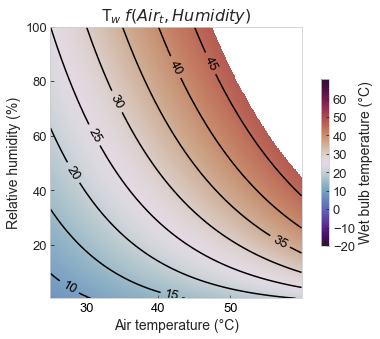

In [10]:
xx = xx_temp
yy = yy_humidity
var_colores = WBT_matrix
colormap = 'twilight_shifted'
levels = np.arange(-20, 71, 0.2)
unit_colores = 'Wet bulb temperature (°C)'

fig = plt.figure(figsize=(5, 5))
cs = plt.contourf(xx, yy, var_colores, cmap = colormap, levels = levels)
cb = plt.contour(xx,yy,var_colores,colors = 'Black',levels= np.arange(-10,70,5))
plt.clabel(cb, fmt = '%2.1d', colors = 'k', fontsize=13) #contour line labels

plt.title('T$_w$ $f (Air_{t},Humidity)$', fontsize = 16)

#Configuración de colorbar
cbar = plt.colorbar(cs,pad=0.07,fraction=0.03,ticks=list(np.arange(-20,70,10)))
cbar.ax.tick_params(labelsize=13)
cbar.set_label(unit_colores,fontsize = 14)

plt.xlabel('Air temperature (°C)')
plt.ylabel(hum_label)  
plt.show();plt.close()

**Reading the personal profile information:** This is the text file where you can customize anthropometrics, activities and clothing for your target population. To understand better the meaning, use and implications of human heat exchange, we recommend reading Cramer and Jay (2019).

*Cramer, M. N., & Jay, O. (2019). Cores of reproducibility in physiology partitional calorimetry. Journal of Applied Physiology, 126(2), 267–277. https://doi.org/10.1152/japplphysiol.00191.2018*

- `id`: identification of your profile
- `name`: name to add labels in the graphics (once this has spaces, it is not the best to use to save outputs
- `name_profile`: name of the text file with this information
- `Mass`: Mass of the human body (kg)
- `Height`: Height of the human body (m)
- `AD`: Dubois-Dubois surface corporal area (m2)
- `Tsk_C`: Mean skin temperature (⁰C)
- `A_eff`: Effective radiative area of the body (dimensionless)	
- `Emm_sk`: Area weighted emissivity of the clothed body surface (dimensionless)	
- `Icl`: Clothing insulation value (Iclo)	
- `Re_cl`: Evaporative heat transfer resistance of the clothing layer (m2·kPa/W)	
- `M`: (Hprod) Internal metabolic heat production in W/kg 
- `W`: External work performed by the person W/g (For this application W=0).
- `wmax_condition`: Maximum skin wettedness bibliography source to be set with PyHHB. (dimensionless)
- `smax_rate`: Maximum sustained sweat rate (L/hr)

**Disclaimer** `M` here is not the rate of metabolic energy expenditure as taken in Cramer and Jay, (2019) in Watts. For this application, we need the internal metabolic heat production to be a function of a person's weight. The reason behind that is to be able to calculate a maximum permissible net heat loss and thus asses if a linear increase of internal temperature with time will lead to a heat stroke death (See explanation in Vanos, et al. (2023)). 
`M` in this modeling effort represents internal metabolic heat production (Hprod = `M` - `W`), once we assume a null external work performed by the person (W=0).


Here, the value of `M`= 1.8 W/kg is equivalent to 1.5 MET, representing a person resting. To see the detail of the conversion factor from Watts to MET you can see the function documentation of `PyHHB.MetabolicRate_W_to_MET_Mass`.


In [11]:
profile = PyHHB.read_personal_profiles(path_profiles + name_profile+'_survivability.txt')
profile

{'id': '001',
 'name': '18-40 years',
 'name_file': 'Young_adult_survivability',
 'Mass': '56.2',
 'Height': nan,
 'AD': '1.6',
 'Tsk_C': '35',
 'A_eff': '0.70',
 'Emm_sk': '0.98',
 'Icl': '0',
 'Re_cl': '0',
 'M': '1.8',
 'W': '0',
 'wmax_condition': 'YNG_Morris_2021',
 'smax_rate': '0.75'}

If the Dubois-Dubois surface corporal area `AD` is given in the profile file and is obtained from there. otherwise, it is estimated from `Mass` and `Height`:

In [12]:
if ~np.isfinite(float(profile['AD'])):
    AD    = PyHHB.AD_from_mass_height(float(profile['Mass']),float(profile['Height'])) #m2
else:
    AD = float(profile['AD'])

AD =  np.ones(xx_temp.shape)*AD

**Disclaimer**: To simulate a radiation condition representative for **shade or night time**, it is assumed that mean radiant temperature equals air temperature. For **sun-exposed conditions**, we asummed a hypothetical threshold to represent partly-cloudy conditions based on micro-climate measurements from Guzman-Echavarria et al (2022) paper. To do this analysis with actual radiation data, researchers should account for the estimations of mean radiant temperature or operative temperature with the outputs of the climate models.

*Guzman-Echavarria, G., Middel, A., & Vanos, J. (2022). Beyond heat exposure — new methods to quantify and link personal heat exposure, stress, and strain in diverse populations and climates: The journal temperature toolbox. Temperature, 10(03), 358–378. https://doi.org/10.1080/23328940.2022.2149024*

**Here, matrices for environmental variables are created or renamed for homogeneous formatting:** 

In [13]:
Ta_C = xx_temp
Pv_kPa  =   Pv
Av_ms  =  np.ones(xx_temp.shape)*Av_ms# Air velocity (m/s)

if sun == 'Night-Indoors':
    mrt_C  =  Ta_C#indoor mrt = Ta (⁰C)
elif sun == 'Day-Outdoors':
    mrt_C  =  Ta_C + 15 #outdoor mrt = Ta (⁰C) (Threshold to an hyphotetical Partly Cloudy Condition) based on the measurements from Guzman-Echavarria et al (2022)

else:
    raise ValueError("Non-valid radiation condition")

# Model run: estimation of survivability matrix

### Estimation of the human-environment heat exchange avenues:
Setting the **internal heat production** (Hprod) term using `M` parameter from `profile` dictionary:

In [14]:
#Internal heat production at resting (W) equivalent to 1.5 METs
M =  np.ones(xx_temp.shape)* float(profile['M'])* float(profile['Mass']) #W/kg *Kg

**Estimation dry heat loss from the skin (combined heat flux via convection + radiation)**

In [15]:
# Defining properties to estimate the combined convective and radiative heat fluxes.
Tsk_C  = np.ones(xx_temp.shape)*float(profile['Tsk_C']) #Skin temperature, assumed to be held constant at 35°C
Emm_sk = np.ones(xx_temp.shape)*float(profile['Emm_sk']) #Area-weighted emissivity of the clothed body surface (dimensionless)
Ar_AD  = np.ones(xx_temp.shape)*float(profile['A_eff']) #Effective radiative area of the body (dimensionless)
Icl    = np.ones(xx_temp.shape)*float(profile['Icl']) #Insulation clothing value (CLO)


hc_cof  = PyHHB.hc_cof_from_Av(Av_ms) #W/m2K Convective heat transfer coefficient.
hr_cof  = PyHHB.hr_cof_from_radiant_features(mrt_C,Tsk_C,Emm_sk,Ar_AD) #Linear radiative heat transfer coefficient (W/m2K).
h_cof   = PyHHB.h_coef_from_hc_hr(hc_cof,hr_cof) # Combined heat transfer coefficient (W/m2K).
to_C    = PyHHB.to_from_hr_tr_hc_ta(hr_cof,mrt_C,hc_cof,Ta_C) #Operative temperature (⁰C)

#Estimation of combined dry heat loss via convection and radiation (W)
Dry_Heat_Loss =  PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C,to_C,Icl,h_cof,AD)


**Heat loss from respiration (Convection + Evaporation)**

In [16]:
# Estimation of dry respiratory heat loss (W)
Cres = PyHHB.Cres_from_M_Ta(M,Ta_C,AD)
# Estimation of latent respiratory heat loss (W)
Eres = PyHHB.Eres_from_M_Pa(M,Pv_kPa,AD)

Once we have all the avenues of heat exchange (Equation 4 in the supplemental material), we can estimate the **Evaporative required heat loss** `Ereq` (Equation 14 in the supplemental material).

In [17]:
Re_cl = np.ones(xx_temp.shape)*float(profile['Re_cl']) #Evaporative resistance of clothing in m2·kPa/W

#Estimation of evaporative required heat loss (W) 
Ereq = PyHHB.Ereq_from_HeatFluxes(M,0,Dry_Heat_Loss,Cres, Eres)

Now, we are getting closer, and we are ready to estimate the different evaporative heat loss restrictions (`Emax_env`, `Emax_wettedness`, and `Emax_sweat`) that will ultimately determine if a person can survive or not in a thermal environment for 3 or 6 hours of steady-state exposure.

**Estimation biophysical (environmental + clothing) evaporative heat loss limit**

This is directly linked with the humidity gradient between the environment and the skin surface and clothing resistance in the heat exchange (Equation 16 in the supplemental material). In very high humid climates, the drivers of evaporation are highly limiting.

In [18]:
#Water vapour pressure at the skin (kPa), assumed to be that of saturated water (100% HR) vapour at skin temperature.
Psk_s= PyHHB.Psa_kPa_from_TaC(Tsk_C) 
# Evaporative heat transfer coefficient (W/m2kPa).
he_cof = PyHHB.he_cof(hc_cof)

# Estimation of biophysical Emax (Env + clothing) (W)
Emax_env = PyHHB.Emax_env(Psk_s,Pv_kPa,Re_cl,he_cof,Icl,AD)
Emax_env[Emax_env<0] = 0 #This heat flux can not be negative.

**Estimation of the physiological (environmental + clothing + sweating capacity) evaporative heat loss limit**

This is linked with the physiological capacity to saturate the skin surface due to a limited maximum skin wettedness (`wmax`) given their age and/or degree of acclimation/acclimatization, among other factors. In this evaporative limit, the biophysical limit is scaled by the maximum skin wettedness (Equation 19 in the supplemental material).

In [19]:
# Maximum skin wettedness: maximum portion of total body surface area that can be saturated with sweat.
wmax = np.ones(xx_temp.shape)*PyHHB.wmax(profile['wmax_condition'])

# Physiological Emax (Env + clothing + wettedness) 
Emax_wettedness = PyHHB.Emax_wettedness(wmax,Psk_s,Pv_kPa,Re_cl,he_cof,Icl,AD)
Emax_wettedness[Emax_wettedness<0] = 0   #This heat flux can not be negative.     

**Estimation of the physiological evaporative heat loss limit given by sweat production**

In very hot and dry environments, evaporation is so efficient, and the sweating rate required to attain `Emax_env` may not be physiologically possible. The evaporative heat loss limit should account for the maximum rate (`Smax`, from `profile` dictionary) at which a person can segregate sweat. 

To be able to estimate the required sweat rate `Sreq` using the required evaporative heat loss to achieve heat balance `Ereq` , it is also necessary to know ahead of the expected sweating efficiency `r`, estimated as follows:

In [20]:
# Estimation of required skin wettedness (dimensionless)
wreq = PyHHB.wreq_HSI_skin_wettedness(Ereq,Emax_env)
# Estimation of expected sweating efficiency (dimensionless)
r = PyHHB.Sweating_efficiency_r(wreq) 
#Estimation of required sweat rate  to maintain heat balance (L/h).
Sreq =  PyHHB.Sreq(Ereq,r,Lh_vap)


**Disclaimer**:  `Emax_sweat` assumes that all sweat evaporates over the skin, and the heat loss is equivalent to the heat released by sweat's latent heat of vaporization.

In [21]:
Smax = np.ones(Ta_C.shape)*float(profile['smax_rate']) #Maximum sweat rate (L/h).

#Estimation of the physiological evaporative heat loss based on capacity to secret sweat
Emax_sweat = PyHHB.Emax_sweat_rate(Smax,Lh_vap,1,r)


## Survivability assessment:

Now, we have all the elements needed to apply the workflow criteria to assess if a person could survive the heat for 3 or 6H exposure.
<img src="Survivability_method.png" alt="Survivability_method" width="600"/>

The function `PyHHB.Survivability` takes `exp_time`,`Ereq`,`Emax_wettedness`,`Emax_sweat`,`Sreq`,`Smax`, and `Mass` to apply each criteria of the above workflow and provide two outputs.

`survivability`: A boolean (True, False) variable that dictates whether a person with a given personal profile survives a given thermal environment.

`flag_survivability`: An integer (1 to 5) variable indicating the survivability type/category according to the physiological constraints imposed in this model
1.	survive while remaining within sweating limits
2.	survive despite exceeding sweating limits
3.	not survive because the environment restricts heat loss too much (in high humidity)
4.	not survive because the required sweat rate is not possible (in low humidity)
5.	not survive due to both critical environmental heat loss restrictions (3rd argument) and not possible sweat rate to dissipate heat (4th argument).

In [22]:
survivability, flag_survivability = PyHHB.Survivability(exp_time,Ereq,Emax_wettedness,Emax_sweat,Sreq,Smax,float(profile['Mass']))

In [23]:
survivability

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [24]:
flag_survivability

array([[1., 1., 1., ..., 4., 4., 4.],
       [1., 1., 1., ..., 4., 4., 4.],
       [1., 1., 1., ..., 4., 4., 4.],
       ...,
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.]])

## Saving the matrices as text files

In [25]:
# Saving survivability matrix as text file
dfsurvivability = pd.DataFrame(index = humidity, columns = temperature)
dfsurvivability[:] = survivability
dfsurvivability.to_csv(path_save+version+'_survivability_array_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',header=True,index = True)

# Saving survivability flags as text file
dfflagsurvivability = pd.DataFrame(index = humidity, columns = temperature)
dfflagsurvivability[:] = flag_survivability
dfflagsurvivability.to_csv(path_save+version+'_flag_survivability_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',header=True,index = True)



In [26]:
## Obtaining survivability lines to plot

In [27]:
# Survivability lines limits estimation            
survivability_lines = PyHHB.SurvivabilityLines_from_SurvivabilityMatrix(survivability,humidity,version,temperature,WBT_matrix)
# Survivability lines text files saving
survivability_lines.to_csv(path_save+version+'_version_NewSurvivability_limits_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',header=True)                

survivability_lines

,rh,Tair,Tw
0,0.5,54.6,18.62
1,1.0,54.5,19.13
2,1.5,54.5,19.65
3,2.0,54.4,20.12
4,2.5,54.4,20.6
...,...,...,...
195,98.0,34.5,34.22
196,98.5,34.5,34.29
197,99.0,34.4,34.26
198,99.5,34.3,34.23


# Now, the funniest part is plotting the results!

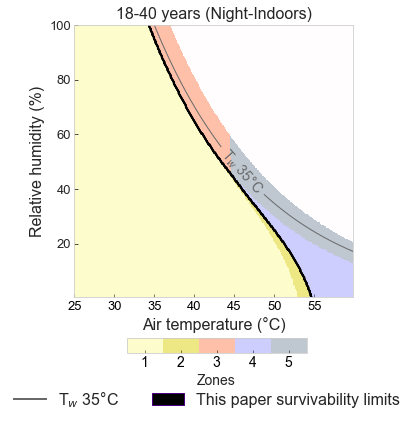

In [38]:
xx = xx_temp
yy = yy_humidity
plt.close('all')
fig = plt.figure(figsize=(5,5))

#Ploting survivability line
cb = plt.contour(xx,yy,survivability,colors = 'Black',lw=0.1)
#Ploting survivability flags
cs = plt.pcolormesh(xx,yy,flag_survivability,cmap = cmap_survivability,vmin=0.5, vmax=5.5, norm = norm_survivability)

#Setting wbt
cp = plt.contour(xx,yy,WBT_matrix,colors = 'Dimgrey', levels= [35],linewidths=(1,))
plt.clabel(cp, fmt = 'T$_w$ %2.1d°C', colors = 'Dimgrey', manual= [(55,70)],fontsize=14) #contour line labels

#Mask for values above Tw > 37°C because are not plausible to occur.
WBT_matrix[~np.isfinite(WBT_matrix)]= 40 #This line is just to do something with the values that are nan in WBT matrix   
plt.contourf(xx,yy,WBT_matrix[WBT_matrix>37],cmap = 'seismic',levels =[6,np.nanmax(WBT_matrix)],zorder =2)

#Setting plot labels
plt.title(profile['name'] + " ("+sun+")", fontsize = 16)
plt.xlabel('Air temperature (°C)', fontsize = 16)
plt.ylabel(hum_label,fontsize = 16)


#Setting colorbar
cax = fig.add_axes([0.27, -0.03, 0.5, 0.04])
cbar = plt.colorbar(cs, cax=cax,pad=0.08,fraction=0.04,ticks=[ticks_survivability],orientation = 'horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(ticks_survivability) 
cbar.set_label('Zones',fontsize = 14)
        
#Setting legend
legend_elements = [Line2D([0], [0], color='DimGrey', lw=2, label='T$_w$ 35°C'),
                    Patch(facecolor='Black', edgecolor='Indigo', label='This paper survivability limits')]
plt.legend(handles=legend_elements,bbox_to_anchor=(1.6,-1.5),fontsize =16,ncol =2)


plt.savefig(path_save+version+'_Survivability_Flags_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.jpeg',dpi=300,transparent=False,bbox_inches='tight')   
plt.show();plt.close()
            